In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random
# from collections import Counter
import plotly.express as px
import os
from os.path import isfile, join
import random
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(20000)
print(sys.getrecursionlimit())
%matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display
import warnings
from skimage.morphology import disk
from skimage.filters import rank
from skimage.color import rgb2gray
import skimage.data 
import matplotlib.image as mpimg   #to get image

20000
20000


### K means clustering

In [ ]:
def image_cluster(im,k):
  clustered_im = im  
  centroids = np.zeros([k,3]).astype(int)
  new_centroids = np.zeros([k,3])
  for i in range(k):
    centroids[i,:] = [random.randint(0,256),random.randint(0,256),random.randint(0,256)]
    new_centroids[i,:] = ['inf','inf','inf']
  
  cluster_color_id = np.zeros([k,3]).astype(int)
  cluster_color_id[:,0] = np.linspace(0, 255 , num=k)
  cluster_color_id[:,1] = np.linspace(255, 0 , num=k)
  cluster_color_id[0:int((k+1)/2),2] = cluster_color_id[int(k/2):k,0]
  cluster_color_id[int((k+1)/2):k,2] = cluster_color_id[0:int(k/2),0]
  
  n = 0
  dictionary = {}
  while error_l2_norm(centroids,new_centroids,k) >= 0.01 * k:
    centroids = new_centroids
    if n == 0:
      new_centroids = np.zeros([k,3])
      n += 1
    dist = np.zeros([k])
    
    points_in_centroid = np.zeros([k])
    for i in range(im.shape[0]):
      for j in range(im.shape[1]):
        for m in range(k):
          dist[m] = np.linalg.norm(im[i][j]-centroids[m,:], ord=None)
        min_dist = np.argmin(dist)
        dictionary[(i,j)] = min_dist
        points_in_centroid[min_dist] +=1
        new_centroids[min_dist,:] = (new_centroids[min_dist,:] * (points_in_centroid[min_dist] - 1) + im[i][j]) / points_in_centroid[min_dist]
        # points_in_centroid = Counter(dictionary.values())
        # new_centroids[min_dist,:] = (new_centroids[min_dist,:] * (points_in_centroid[min_dist] - 1) + im[i][j]) / points_in_centroid[min_dist]

  for i in range(im.shape[0]):
    for j in range(im.shape[1]):
      a = dictionary[(i,j)]
      clustered_im[i][j] = cluster_color_id[a,:]

  return clustered_im

In [ ]:
#function for total residual error between the old and new centriods
def error_l2_norm(x,y,k):
  error = 0
  for i in range(k):
    error += np.linalg.norm(x[i,:]-y[i,:], ord=None)
  return error


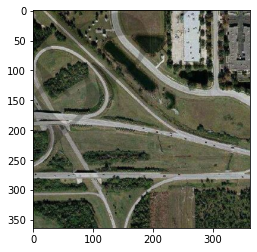

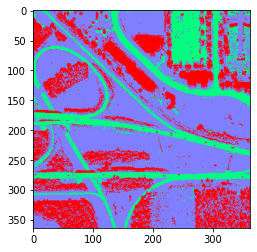

In [ ]:
map = cv2.imread("/content/drive/MyDrive/PROJECTS/Project/DIP Photos/1. Input images/final images/im1.JPG")
map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
plt.imshow(map)
plt.show()

clustered_image = image_cluster(map,3)
plt.imshow(clustered_image)
plt.show()
#cv2.imwrite('/content/drive/MyDrive/DIP project/Segmented maps/clustered_image1.png',cv2.cvt

## Road cluster identification and Filtering

In [ ]:
#Function to give the cluster arrays
#Input: K-Means output image
#Output: Produces k arrays, where in each array the kth cluster pixels will have value 1 and remaining pixels will have value 0

def clusters_segmentation(array_to_be_segmented):
  final_segmented_array = []
  check_value_list = np.unique(array_to_be_segmented)
  #print(check_value_list)
  r = len(array_to_be_segmented)
  c = len(array_to_be_segmented[0])
  for i in  range(len(check_value_list)):
    temp_f = []
    for j in range(r):
      temp_a = []
      for k in range(c):
        if(array_to_be_segmented[j][k] == check_value_list[i]):
          temp_a.append(1)
        else:
          temp_a.append(0)
      temp_f.append(temp_a)
    final_segmented_array.append(temp_f)
  return final_segmented_array

In [ ]:

#Function to produce the longest connected component
#Input: Clustered Image
#Output: 2 values: 
# 1) maxi_row which contains maxiumum connected component in each row 
# 2) maxi_col which contains maxiumum connected component in each column
def longest_connected_component(clustered_image):
    
    r = len(clustered_image)
    c = len(clustered_image[0])
 
    maxi_col = []
    temp_count_col = -1

    for j in range(r):
        temp_count  = 0
        for k in range(c-1):
            if(clustered_image[j][k] == 1) and (clustered_image[j][k+1]!=0):
                temp_count += 1
            else:
                temp_count += 1
                if(temp_count > temp_count_col):
                    temp_count_col = temp_count
                    temp_count  = 0 
        maxi_col.append(temp_count_col)
        temp_count_col = 0
  
    maxi_row = []
    temp_count_row = -1
    for j in range(c):
        temp_count = 0
        for k in range(r-1):
            if(clustered_image[k][j] == 1) and (clustered_image[k+1][j]!=0):
                temp_count  += 1
            else:
                temp_count += 1 
                if(temp_count > temp_count_row):
                    temp_count_row = temp_count
                    temp_count  = 0 
        maxi_row.append(temp_count_row)
        temp_count_row=0
    
    maxi_row_count = 0
    max_col_count = 0
    for i in range(len(maxi_row)):
      if(maxi_row[i] > ((r/2))):
        maxi_row_count += 1
    for j in range((len(maxi_col))):
      if(maxi_col[j] > ((c/2))):
        max_col_count += 1


    return maxi_row_count,max_col_count

In [ ]:
#Function to road cluster segmentation
#Input: List of clustered images after clusters_segmentation()
#Output: Road cluster segmented image
def solve(cluster_images_list):
  final_ans = -1
  final_index = -1

  print(len(cluster_images_list))
  for i in range(len(cluster_images_list)):
    r_count, c_count = longest_connected_component(cluster_images_list[i])
    if((r_count + c_count) >= final_ans):
      final_ans = (r_count + c_count) 
      final_index = i

  print(final_index)
  final_clustered_list = cluster_images_list[final_index]
  r =  len(final_clustered_list)
  c =  len(final_clustered_list[0])
  for i in range(r):
    for j in range(c):
      if(final_clustered_list[i][j] == 1):
        final_clustered_list[i][j] = 255
  plt.imshow(final_clustered_list,cmap="gray", vmin=0, vmax=255)
  plt.show()
  #Uncomment these to write the image
  #a = np.array(final_clustered_list)
  #cv2.imwrite('C:/Users/Radha Krishna/final_image_1.png',a)

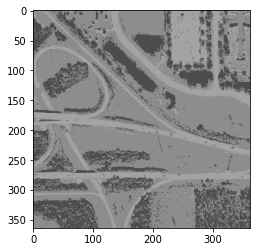

(364, 363)
[ 76 141 164]


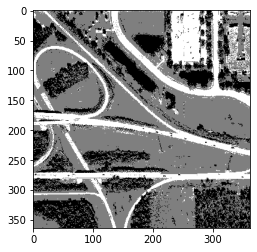

[  0 127 255]
3
2


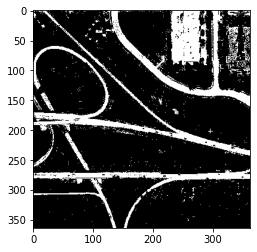

In [ ]:
#Reading the image after k-means clustering
cimage_b = cv2.imread("/content/drive/MyDrive/PROJECTS/Project/DIP Photos/2.After K-means/final/c_1.png",0)
plt.imshow(cimage_b,cmap="gray", vmin=0, vmax=255)
plt.show()
print(cimage_b.shape)
print(np.unique(cimage_b))

#Imporivng the intensities for better visualization
r,c = cimage_b.shape
dummy_v = []
for i in range(r):
    t = []
    for j in range(c):
        if(cimage_b[i][j] == 164):
            t.append(255)
        elif(cimage_b[i][j] == 76):
            t.append(0)
        else:
            t.append(127)
    dummy_v.append(t)
plt.imshow(dummy_v,cmap="gray", vmin=0, vmax=255)
plt.show()
print(np.unique(dummy_v))

#Create clusters segmented list
clusters_segmented_array = clusters_segmentation(dummy_v)
#Call the solve method with clustered segemneted images as input
solve(clusters_segmented_array)

## Image dilation and erosion

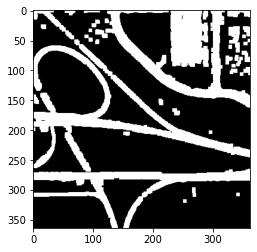

In [ ]:
image = cv2.imread('/content/drive/MyDrive/PROJECTS/Project/DIP Photos/3.Road Identification/final/final_image_1.png',0)
kernel_dil = np.ones((6,6), np.uint8)
kernel_ero = np.ones((2,2), np.uint8)
img_erode = cv2.erode(image, kernel_ero, iterations=1)
img_dilate = cv2.dilate(img_erode, kernel_dil, iterations=1)
plt.imshow(img_dilate, cmap='gray')
